# Analisi finale

Si individuano 5 rettangoli attorno a delle minutiae (punti caratteristici) di interesse per entrambe le immagini. Le aree vengono individuate sulla prima immagine, con l'impronta di Canova, e successivamente mappate sulla seconda immagine sfruttando la sovrapposizione fornita dal committente, che viene assunta come valida.

Vengono successivamente effettuati diversi test a coppie per la differenza di medie nei valori dei pixel. Si lavora trasformando la sezione dell'immagine in un vettore, perdendo così la nozione spaziale, ma in questo modo si riesce a fornire una risposta al quesito originale che permette di sorpassare il problema della bassa qualità delle immagini.

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

## Impronte

In [2]:
img_path = '../data/final/'
fig_path = './figures/'

images = [
    Image.open(img_path + 'sg_box.jpg'), 
    Image.open(img_path + 'mc_box.jpg')
]

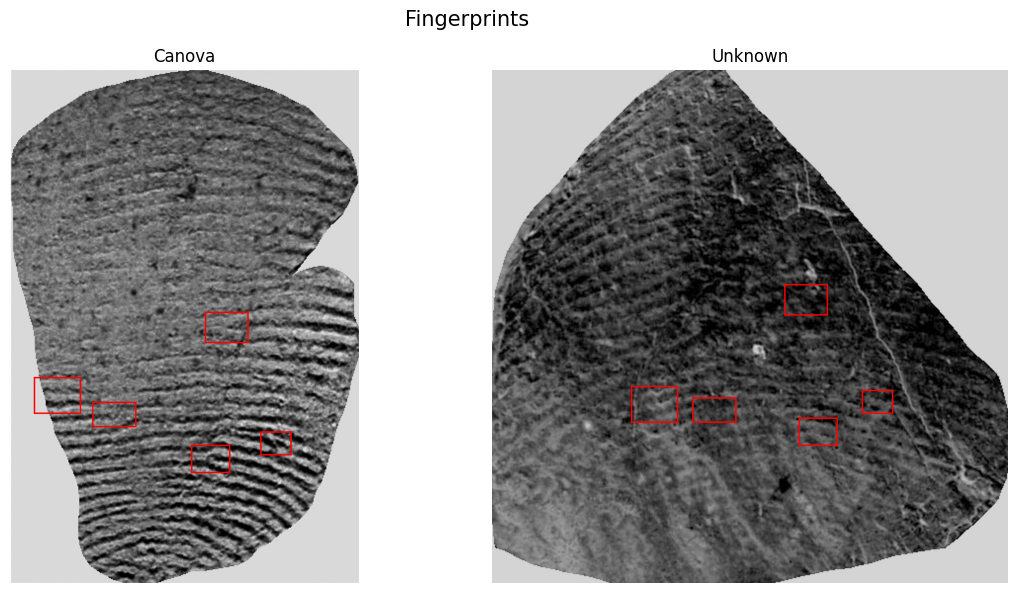

In [3]:
# plot 
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle('Fingerprints', fontsize = 15)

for ax, im, tit in zip(axs.flat, images, ['Canova', 'Unknown']):
    ax.imshow(im, cmap='Greys')
    ax.set_title(tit)
    ax.axis('off')

fig.tight_layout()
plt.savefig(fig_path + 'fingerprints.jpg')

In [4]:
# convert to greyscale
images = [im.convert('L') for im in images]

## Aree di interesse

In [5]:
# define boxes

# vertices1 = [
#     # y1 (topleft), y2, x1 (bottomright), x2 
#     [491, 552, 395, 481], # box 1, in alto poi antiorario
#     [623, 695, 50, 142],
#     [673, 721, 168, 255],
#     [760, 815, 368, 445],
#     [733, 779, 508, 569]
# ]

# vertices2 = [ 
#     [435, 496, 592, 678], 
#     [640, 713, 282, 376], 
#     [664, 713, 406, 493], 
#     [705, 760, 621, 698],
#     [648, 695, 749, 810]
# ]

# narrower to remove the box
vertices1 = [
    # y1 (topleft), y2, x1 (bottomright), x2 
    [492, 550, 397, 480], # box 1, in alto poi antiorario
    [624, 693, 51, 141],
    [674, 720, 169, 253],
    [761, 813, 369, 443],
    [734, 777, 509, 567]
]

vertices2 = [ 
    [436, 494, 594, 677], 
    [642, 711, 284, 374], 
    [665, 711, 408, 492], 
    [706, 758, 623, 697],
    [650, 693, 751, 809]
]



ncrops = len(vertices1)
crops = [
    [np.array(images[0])[v[0]:v[1], v[2]:v[3]] for v in vertices1],
    [np.array(images[1])[v[0]:v[1], v[2]:v[3]] for v in vertices2]
]

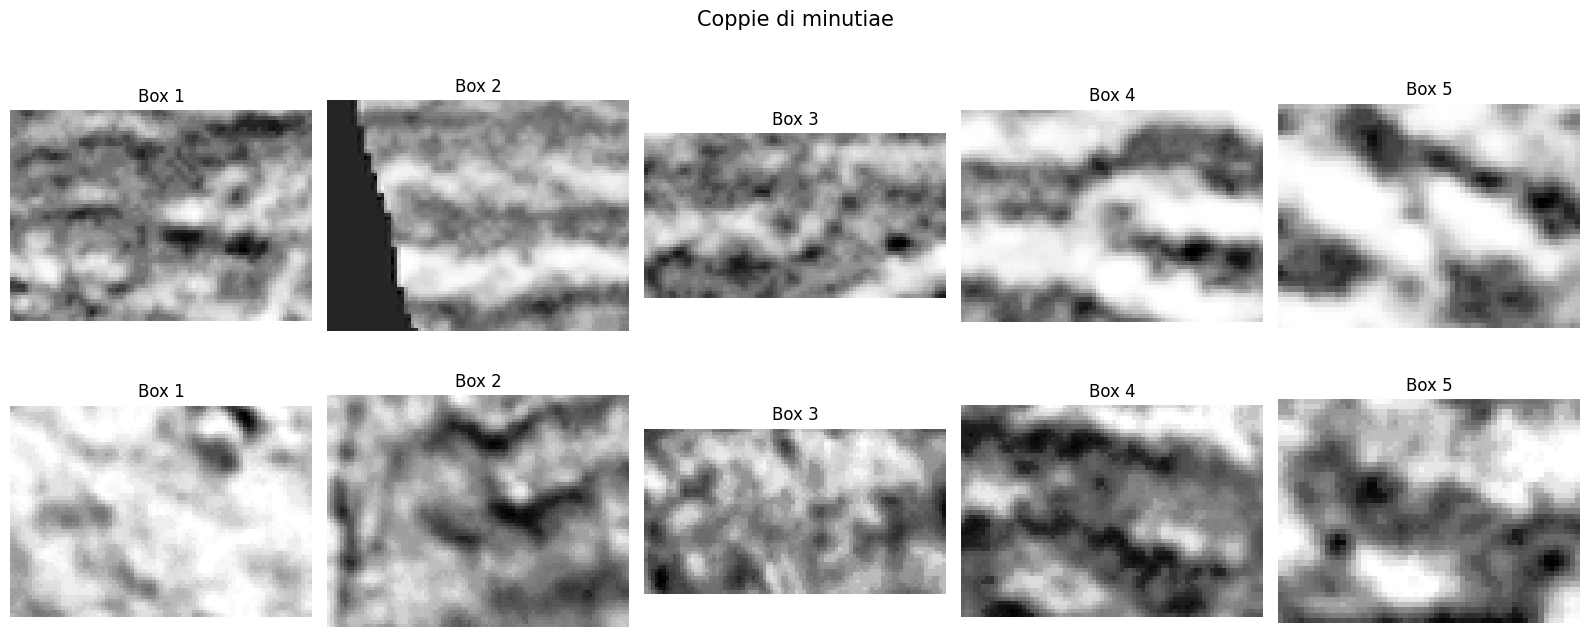

In [6]:
# plot boxes

fig, axs = plt.subplots(2, 5, figsize = (16, 7))
fig.suptitle('Coppie di minutiae', fontsize = 15)

for i in range(len(crops)):
    for j in range(ncrops):
        im = crops[i][j]
        axs[i][j].imshow(im, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].set_title(f'Box {j+1}')

fig.tight_layout()
plt.savefig(fig_path + 'paired_boxes.jpg')

(-0.5, 89.5, 68.5, -0.5)

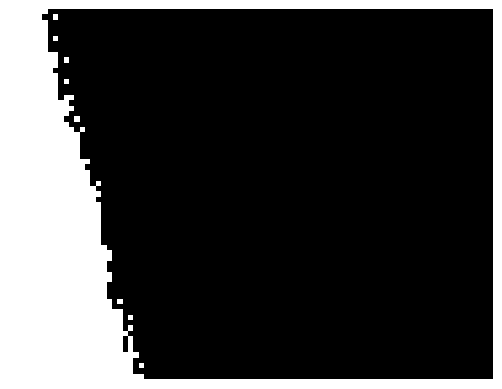

In [7]:
# mask for Canova - Box 2
mask = (crops[0][1] < 215) | (crops[0][1] > 218)
mask[:, 50:] = True

plt.imshow(mask, cmap='Greys')
plt.axis('off')

## Test a due campioni 

In [8]:
# helper functions

def print_results(res_dict):
    '''Print formatted result dictionary'''

    print('test\t\tstat\t\tp-value')
    print('-'*40)
    for k, v in res_dict.items():
        print(f'{k:10}\t{v[0]:.6f}\t{v[1]:.6f}') 

def two_samples_tests(x1, x2):
    '''Perform different parametric and non-parametric tests for equal location on two independent samples'''

    res = {}
    res['t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=True, alternative='two-sided') # t-test with pooled variance for two independent samples
    res['welch t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, alternative='two-sided') # t-test without assumption of equal variance
    res['yuen t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, trim=0.1, alternative='two-sided') # t-test with trimming of each tail
    res['kruskal'] = sp.stats.kruskal(x1, x2) # non parametric test for equal median on indepdent samples
    # res['mann-whitney'] = sp.stats.mannwhitneyu(x1, x2) # non parametric test for equal distribution of two independent samples
    # res['wilcoxon'] = sp.stats.wilcoxon(x1, x2, alternative='two-sided') # non parametric test for diffrences simmetric about 0 in two paired samples

    return res

In [9]:
print('Test a due campioni per ogni box')

# get reshaped and normalized arrays
samples_mc = [crop.reshape(-1)/255 for crop in crops[0]]
samples_sg = [crop.reshape(-1)/255 for crop in crops[1]]

# filter using mask for box2
samples_mc[1] = samples_mc[1][mask.reshape(-1)]
samples_sg[1] = samples_sg[1][mask.reshape(-1)]

# test loop
results = []
for i in range(ncrops):

    # take the two samples
    x1 = samples_mc[i]
    x2 = samples_sg[i]

    # perform tests
    res = two_samples_tests(x1, x2)
    results.append(res)

    # print results
    print(f'\nBox {i+1}')
    print_results(res) 

Test a due campioni per ogni box

Box 1
test		stat		p-value
----------------------------------------
t-test    	121.217392	0.000000
welch t-test	121.217392	0.000000
yuen t-test	116.842065	0.000000
kruskal   	5924.089290	0.000000

Box 2
test		stat		p-value
----------------------------------------
t-test    	45.419575	0.000000
welch t-test	45.419575	0.000000
yuen t-test	45.837351	0.000000
kruskal   	1849.286232	0.000000

Box 3
test		stat		p-value
----------------------------------------
t-test    	77.318561	0.000000
welch t-test	77.318561	0.000000
yuen t-test	73.732867	0.000000
kruskal   	3420.587265	0.000000

Box 4
test		stat		p-value
----------------------------------------
t-test    	10.158750	0.000000
welch t-test	10.158750	0.000000
yuen t-test	5.708057	0.000000
kruskal   	42.177549	0.000000

Box 5
test		stat		p-value
----------------------------------------
t-test    	19.764493	0.000000
welch t-test	19.764493	0.000000
yuen t-test	14.450744	0.000000
kruskal   	205.837074	0.000000


In [10]:
print('Mettendo insieme tutti i box\n')

# put every box together
mc1 = np.concatenate(samples_mc)
sg1 = np.concatenate(samples_sg)

# perform tests
res = two_samples_tests(mc1, sg1)

# print results
print_results(res)

Mettendo insieme tutti i box

test		stat		p-value
----------------------------------------
t-test    	99.152165	0.000000
welch t-test	99.152165	0.000000
yuen t-test	95.764055	0.000000
kruskal   	8011.677486	0.000000


## Proof of work

In [11]:
# seed 
np.random.seed(42)

# box4 di canova
t1 = crops[0][3]

# random normal perurbation
sd_list = [3, 5, 10, 20, 30]
for_proof = [np.clip(t1 + np.random.normal(0, sd, t1.shape), 0, 255) for sd in sd_list]

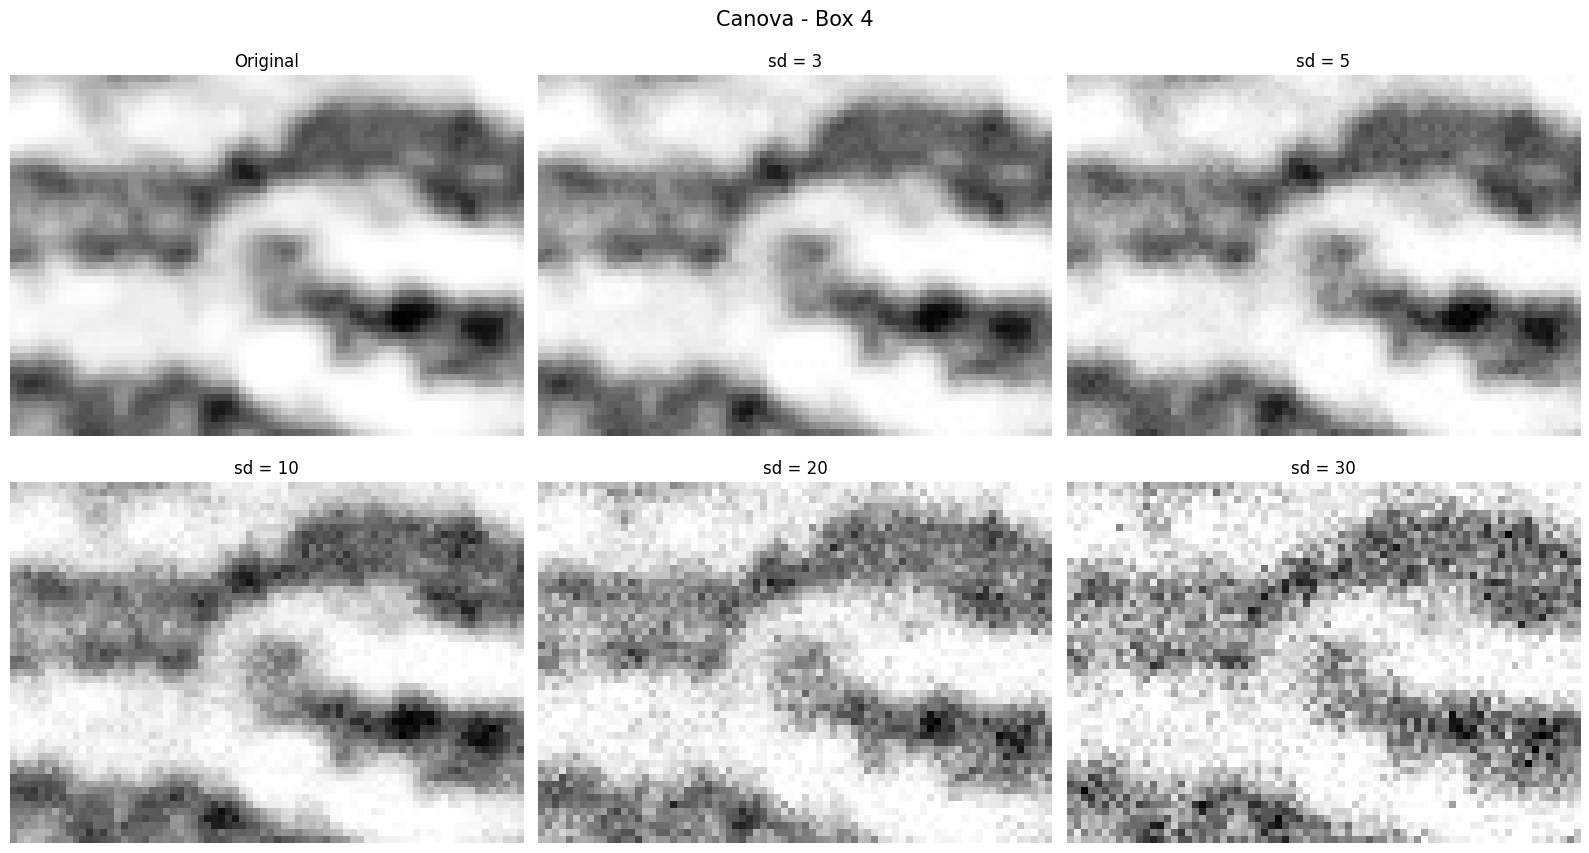

In [12]:
# plot boxes

fig, axs = plt.subplots(2, 3, figsize = (16, 9))
fig.suptitle('Canova - Box 4', fontsize = 15)

for i, ax in enumerate(axs.flatten()):

    if i==0:
        im = t1
        ax.imshow(im, cmap='Greys')
        ax.axis('off')
        ax.set_title(f'Original')
    else:
        im = for_proof[i-1]
        ax.imshow(im, cmap='Greys')
        ax.axis('off')
        ax.set_title(f'sd = {sd_list[i-1]}')

fig.tight_layout()
plt.savefig(fig_path + 'for_proof_1.jpg')

In [13]:
print("Test di prova utilizzando perturbazioni casuali di un'immagine scelta")

results = []
x1 = t1.reshape(-1)/255
for i, im in enumerate(for_proof):

    # take the two samples
    x2 = im.reshape(-1)/255

    # perform tests
    res = two_samples_tests(x1, x2)
    results.append(res)

    # print results
    print(f'\nsd = {sd_list[i]}')
    print_results(res) 

Test di prova utilizzando perturbazioni casuali di un'immagine scelta

sd = 3
test		stat		p-value
----------------------------------------
t-test    	-0.101237	0.919365
welch t-test	-0.101237	0.919365
yuen t-test	-0.030588	0.975599
kruskal   	0.046681	0.828944

sd = 5
test		stat		p-value
----------------------------------------
t-test    	-0.010268	0.991808
welch t-test	-0.010268	0.991808
yuen t-test	0.060344	0.951884
kruskal   	0.001162	0.972802

sd = 10
test		stat		p-value
----------------------------------------
t-test    	-0.275125	0.783228
welch t-test	-0.275125	0.783228
yuen t-test	-0.020996	0.983249
kruskal   	0.023195	0.878952

sd = 20
test		stat		p-value
----------------------------------------
t-test    	-1.000558	0.317072
welch t-test	-1.000558	0.317072
yuen t-test	-0.394475	0.693244
kruskal   	0.384951	0.534965

sd = 30
test		stat		p-value
----------------------------------------
t-test    	-1.857949	0.063214
welch t-test	-1.857949	0.063215
yuen t-test	-0.567825	0.570175
kr

In [14]:
# seed 
np.random.seed(42)

# box2 di unknown
t1 = crops[1][1]

# random normal perurbation
sd_list = [3, 5, 10, 20, 30]
for_proof = [np.clip(t1 + np.random.normal(0, sd, t1.shape), 0, 255) for sd in sd_list]

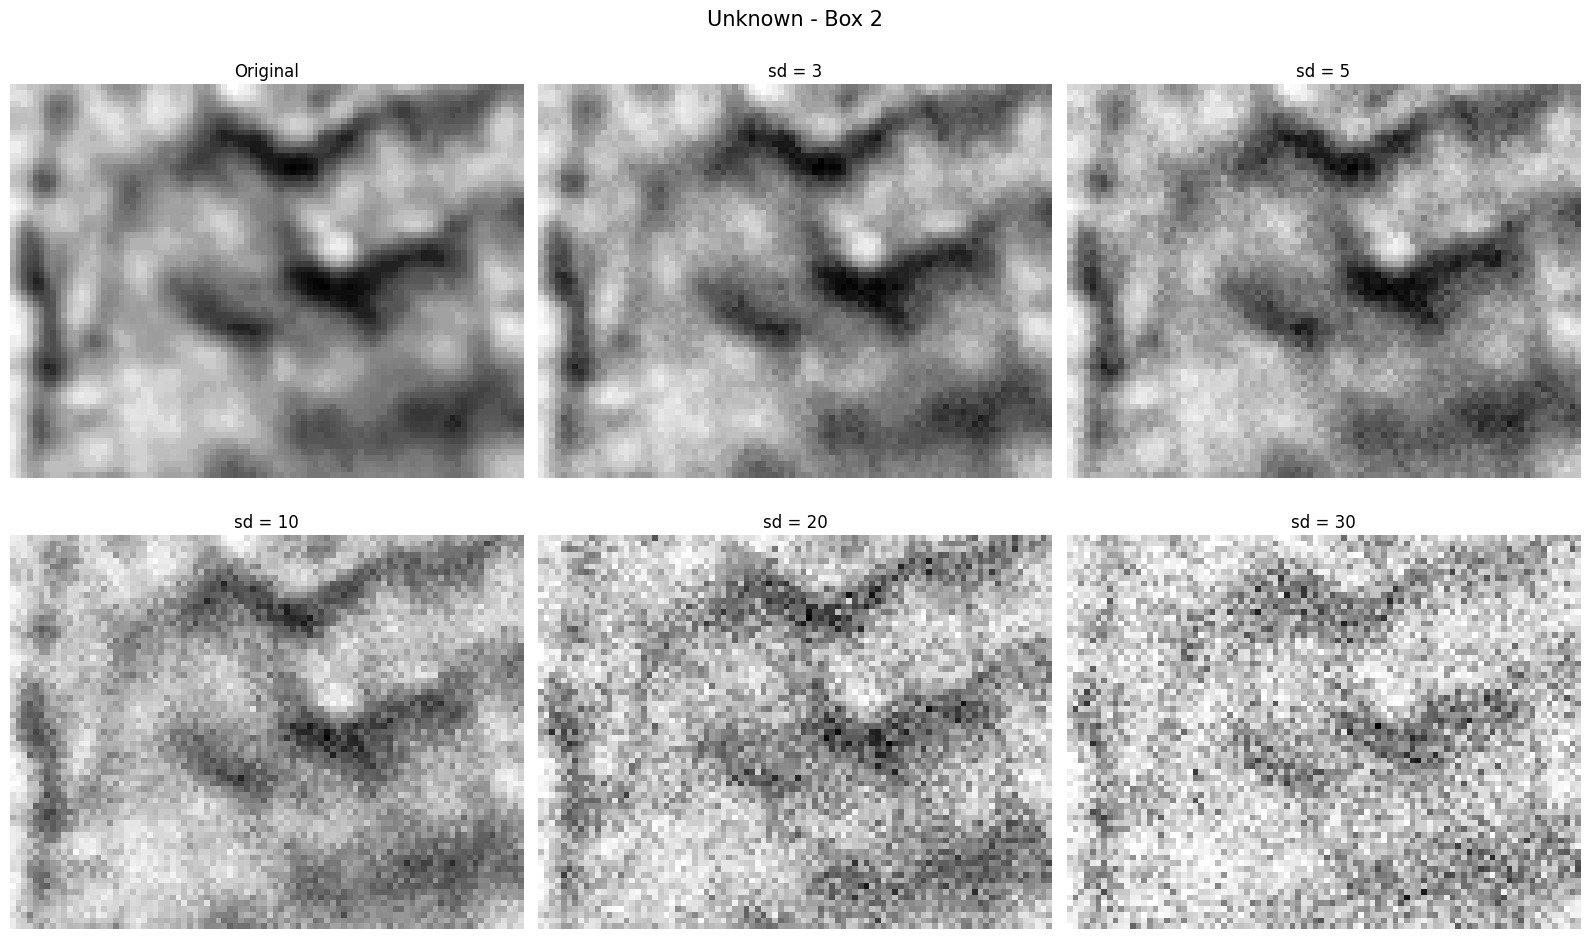

In [15]:
# plot boxes

fig, axs = plt.subplots(2, 3, figsize = (16, 10))
fig.suptitle('Unknown - Box 2', fontsize = 15)

for i, ax in enumerate(axs.flatten()):

    if i==0:
        im = t1
        ax.imshow(im, cmap='Greys')
        ax.axis('off')
        ax.set_title(f'Original')
    else:
        im = for_proof[i-1]
        ax.imshow(im, cmap='Greys')
        ax.axis('off')
        ax.set_title(f'sd = {sd_list[i-1]}')

fig.tight_layout()
plt.savefig(fig_path + 'for_proof_1.jpg')

In [16]:
print("Test di prova utilizzando perturbazioni casuali di un'immagine scelta")

results = []
x1 = t1.reshape(-1)/255
for i, im in enumerate(for_proof):

    # take the two samples
    x2 = im.reshape(-1)/255

    # perform tests
    res = two_samples_tests(x1, x2)
    results.append(res)

    # print results
    print(f'\nsd = {sd_list[i]}')
    print_results(res) 

Test di prova utilizzando perturbazioni casuali di un'immagine scelta

sd = 3
test		stat		p-value
----------------------------------------
t-test    	0.010518	0.991608
welch t-test	0.010518	0.991608
yuen t-test	0.113582	0.909571
kruskal   	0.001659	0.967508

sd = 5
test		stat		p-value
----------------------------------------
t-test    	0.059575	0.952495
welch t-test	0.059575	0.952495
yuen t-test	0.094949	0.924357
kruskal   	0.003154	0.955214

sd = 10
test		stat		p-value
----------------------------------------
t-test    	-0.513428	0.607661
welch t-test	-0.513428	0.607661
yuen t-test	-0.528238	0.597346
kruskal   	0.298471	0.584842

sd = 20
test		stat		p-value
----------------------------------------
t-test    	0.452548	0.650882
welch t-test	0.452548	0.650882
yuen t-test	0.219354	0.826379
kruskal   	0.125293	0.723363

sd = 30
test		stat		p-value
----------------------------------------
t-test    	-0.458223	0.646801
welch t-test	-0.458223	0.646802
yuen t-test	-0.461338	0.644567
kruskal   